In [1]:
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cuda


In [2]:
# Utility functions
def display_eval(epoch, epochs, tlength, global_step, tcorrect, tsamples, t_valid_samples, average_train_loss, average_valid_loss, total_acc_val):
    tqdm.write(
        f'Epoch: [{epoch + 1}/{epochs}], Step [{global_step}/{epochs*tlength}] | Train Loss: {average_train_loss: .3f} \
        | Train Accuracy: {tcorrect / tsamples: .3f} \
        | Val Loss: {average_valid_loss: .3f} \
        | Val Accuracy: {total_acc_val / t_valid_samples: .3f}')


def save_model(model, optimizer, valid_loss, epoch, path='model.pt'):
    torch.save({'valid_loss': valid_loss,
                'model_state_dict': model.state_dict(),
                'epoch': epoch + 1,
                'optimizer': optimizer.state_dict()
                }, path)
    tqdm.write(f'Model saved to ==> {path}')


def save_metrics(train_loss_list, valid_loss_list, global_steps_list, path='metrics.pt'):
    torch.save({'train_loss_list': train_loss_list,
                'valid_loss_list': valid_loss_list,
                'global_steps_list': global_steps_list,
                }, path)


def plot_losses(path='metrics.pt'):
    state = torch.load(path)

    train_loss_list = state['train_loss_list']
    valid_loss_list = state['valid_loss_list']
    global_steps_list = state['global_steps_list']

    plt.plot(global_steps_list, train_loss_list, label='Train')
    plt.plot(global_steps_list, valid_loss_list, label='Valid')
    plt.xlabel('Global Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [3]:
def train(epochs, train_loader, valid_loader, model, loss_fn, optimizer, eval_every=0.25, best_valid_loss=float("Inf")):
    model.train()

    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    for epoch in range(epochs):
        running_loss = 0.0
        t_correct = 0
        t_samples = 0
        for dl in tqdm(train_loader):
            ids = dl['ids'].to(device)
            mask = dl['mask'].to(device)
            label = dl['target'].to(device)
            label = label.unsqueeze(1)

            optimizer.zero_grad()

            output = model(
                ids=ids,
                mask=mask)
            label = label.type_as(output)

            loss = loss_fn(output, label)
            running_loss += loss.item()*len(ids)
            loss.backward()
            global_step += 1*len(ids)

            optimizer.step()

            pred = torch.where(output >= 0, 1, 0)
            t_correct += sum(1 for a, b in zip(pred, label) if a[0] == b[0])
            t_samples += len(pred)

            if (global_step % (int(eval_every*len(train_loader.dataset)))) < train_loader.batch_size:
                model.eval()

                valid_running_loss = 0.0
                total_acc_val = 0
                with torch.no_grad():

                    for dl in valid_loader:

                        ids = dl['ids'].to(device)
                        mask = dl['mask'].to(device)
                        label = dl['target'].to(device)
                        label = label.unsqueeze(1)

                        output = model(
                            ids=ids,
                            mask=mask)
                        label = label.type_as(output)

                        loss = loss_fn(output, label).item()
                        valid_running_loss += loss*len(ids)

                        pred = torch.where(output >= 0, 1, 0)
                        total_acc_val += sum(1 for a, b in zip(pred,
                                                               label) if a[0] == b[0])

                # evaluation
                average_train_loss = running_loss / t_samples
                average_valid_loss = valid_running_loss / \
                    len(valid_loader.dataset)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                display_eval(epoch, epochs, len(train_loader.dataset), global_step, t_correct, t_samples, len(
                    valid_loader.dataset), average_train_loss, average_valid_loss, total_acc_val)

                # resetting running values
                model.train()

                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_model(model, optimizer, best_valid_loss, epoch)
                    save_metrics(train_loss_list, valid_loss_list,
                                 global_steps_list)

    save_metrics(train_loss_list, valid_loss_list, global_steps_list)
    print("Training complete.")
    return model

In [4]:
def evaluate(model, test_loader):
    model.eval()
    y_pred = []
    y_true = []

    total_acc_test = 0
    with torch.no_grad():
        for dl in test_loader:

            ids = dl['ids'].to(device)
            mask = dl['mask'].to(device)
            label = dl['target'].to(device)
            label = label.unsqueeze(1)

            output = model(
                ids=ids,
                mask=mask)
            label = label.type_as(output)

            pred = torch.where(output >= 0, 1, 0)
            y_pred.extend(pred.tolist())
            y_true.extend(label.tolist())
            total_acc_test += sum(1 for a, b in zip(pred,
                                  label) if a[0] == b[0])

    print('Classification Report:')
    target_names = ['GPT', 'HUMAN']
    print(classification_report(y_true, y_pred, labels=[
          1, 0], target_names=target_names, digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(target_names)
    ax.yaxis.set_ticklabels(target_names)

    print(f'Test Accuracy: {total_acc_test / len(test_loader.dataset): .3f}')

In [5]:
class HC3Dataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, fp="./ds.csv"):
        self.data = pd.read_csv(fp)
        self.tokenizer = tokenizer
        self.max_length = 512

    def __getitem__(self, idx):
        x = self.data['text'][idx]
        x = self.tokenizer.encode_plus(
            x,
            None,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True,
            max_length=self.max_length,
            truncation=True
        )
        ids = x['input_ids']
        mask = x['attention_mask']
        y = self.data['labels'][idx]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'target': torch.tensor(y, dtype=torch.long)
        }

    def __len__(self):
        return len(self.data)

In [6]:
class BERT(nn.Module):
    def __init__(self, bert, dropout=0.1):
        super(BERT, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()

    def forward(self, ids, mask):
        o2 = self.bert(ids, attention_mask=mask, return_dict=False)
        hs = o2[0]
        pooled = hs[:, 0]

        x = self.fc1(pooled)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [7]:
BERT_MODEL = 'distilbert-base-cased'

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
bert = AutoModel.from_pretrained(BERT_MODEL)
load_dataset = False

if load_dataset:
    train_loader = torch.load('./train_loader.pt')
    valid_loader = torch.load('./valid_loader.pt')
    test_loader = torch.load('./test_loader.pt')
else:
    ds = HC3Dataset(tokenizer, "./ds_noqn.csv")
    train_ds, valid_ds, test_ds = torch.utils.data.random_split(ds, [
                                                                0.8, 0.1, 0.1])

    train_loader = torch.utils.data.DataLoader(
        train_ds, batch_size=15, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=15)
    test_loader = torch.utils.data.DataLoader(
        test_ds, batch_size=15, shuffle=True)

    torch.save(train_loader, './train_loader.pt')
    torch.save(valid_loader, './valid_loader.pt')
    torch.save(test_loader, './test_loader.pt')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
checkpoint = False
EPOCH = 5

model = BERT(bert).to(device)

# freeze all the parameters
for param in model.bert.parameters():
    param.requires_grad = False

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

if checkpoint:
    checkpoint = torch.load('model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch = checkpoint['epoch'] - 1
    EPOCH -= epoch - 1

torch.cuda.empty_cache()

model = train(EPOCH, train_loader, valid_loader, model, criterion, optimizer)

  0%|          | 0/3627 [00:00<?, ?it/s]

Epoch: [1/5], Step [13605/271985] | Train Loss:  0.132         | Train Accuracy:  0.951         | Val Loss:  0.394         | Val Accuracy:  0.838
Model saved to ==> model.pt
Epoch: [1/5], Step [27210/271985] | Train Loss:  0.107         | Train Accuracy:  0.961         | Val Loss:  0.068         | Val Accuracy:  0.976
Model saved to ==> model.pt
Epoch: [1/5], Step [40800/271985] | Train Loss:  0.093         | Train Accuracy:  0.966         | Val Loss:  0.057         | Val Accuracy:  0.980
Model saved to ==> model.pt
Epoch: [1/5], Step [54397/271985] | Train Loss:  0.085         | Train Accuracy:  0.969         | Val Loss:  0.097         | Val Accuracy:  0.962


  0%|          | 0/3627 [00:00<?, ?it/s]

Epoch: [2/5], Step [68002/271985] | Train Loss:  0.055         | Train Accuracy:  0.980         | Val Loss:  0.063         | Val Accuracy:  0.976
Epoch: [2/5], Step [81607/271985] | Train Loss:  0.059         | Train Accuracy:  0.978         | Val Loss:  0.120         | Val Accuracy:  0.953
Epoch: [2/5], Step [95197/271985] | Train Loss:  0.057         | Train Accuracy:  0.979         | Val Loss:  0.048         | Val Accuracy:  0.984
Model saved to ==> model.pt
Epoch: [2/5], Step [108794/271985] | Train Loss:  0.054         | Train Accuracy:  0.980         | Val Loss:  0.064         | Val Accuracy:  0.975


  0%|          | 0/3627 [00:00<?, ?it/s]

Epoch: [3/5], Step [122399/271985] | Train Loss:  0.055         | Train Accuracy:  0.980         | Val Loss:  0.075         | Val Accuracy:  0.972
Epoch: [3/5], Step [136004/271985] | Train Loss:  0.050         | Train Accuracy:  0.982         | Val Loss:  0.052         | Val Accuracy:  0.979
Epoch: [3/5], Step [149594/271985] | Train Loss:  0.051         | Train Accuracy:  0.982         | Val Loss:  0.065         | Val Accuracy:  0.975
Epoch: [3/5], Step [163191/271985] | Train Loss:  0.050         | Train Accuracy:  0.982         | Val Loss:  0.055         | Val Accuracy:  0.980


  0%|          | 0/3627 [00:00<?, ?it/s]

Epoch: [4/5], Step [176796/271985] | Train Loss:  0.044         | Train Accuracy:  0.983         | Val Loss:  0.133         | Val Accuracy:  0.951
Epoch: [4/5], Step [190386/271985] | Train Loss:  0.044         | Train Accuracy:  0.984         | Val Loss:  0.039         | Val Accuracy:  0.986
Model saved to ==> model.pt
Epoch: [4/5], Step [203991/271985] | Train Loss:  0.045         | Train Accuracy:  0.983         | Val Loss:  0.066         | Val Accuracy:  0.976
Epoch: [4/5], Step [217588/271985] | Train Loss:  0.045         | Train Accuracy:  0.983         | Val Loss:  0.047         | Val Accuracy:  0.983


  0%|          | 0/3627 [00:00<?, ?it/s]

Epoch: [5/5], Step [231193/271985] | Train Loss:  0.042         | Train Accuracy:  0.985         | Val Loss:  0.072         | Val Accuracy:  0.973
Epoch: [5/5], Step [244783/271985] | Train Loss:  0.042         | Train Accuracy:  0.985         | Val Loss:  0.077         | Val Accuracy:  0.970
Epoch: [5/5], Step [258388/271985] | Train Loss:  0.043         | Train Accuracy:  0.984         | Val Loss:  0.141         | Val Accuracy:  0.948
Epoch: [5/5], Step [271985/271985] | Train Loss:  0.042         | Train Accuracy:  0.984         | Val Loss:  0.177         | Val Accuracy:  0.936
Training complete.


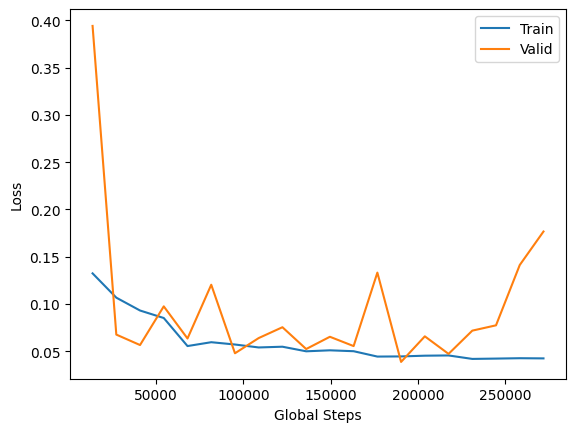

Classification Report:
              precision    recall  f1-score   support

         GPT     0.9989    0.9150    0.9551      5105
       HUMAN     0.7956    0.9970    0.8850      1694

    accuracy                         0.9354      6799
   macro avg     0.8973    0.9560    0.9201      6799
weighted avg     0.9483    0.9354    0.9376      6799

Test Accuracy:  0.935


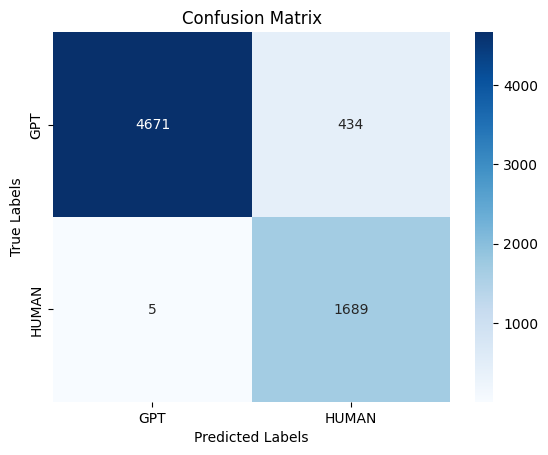

In [9]:
plot_losses()
evaluate(model, test_loader)
